# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>



In [1]:
!pip install -q tensorflow==2.3 

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -U tensorflow-text==2.3.0 # Нужна строго та же версия, что и TF

!pip install -q -U tf-models-official==2.3.0 # Нужна строго та же версия, что и TF

     |████████████████████████████████| 2.6 MB 4.1 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
!pip install pymystem3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import keras

import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import seaborn as sns
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

from tqdm.notebook import tqdm

# You need to install two libraries:
# * nltk - to get russian stopwords
# * pymystem3 - for lemmatization

# download stopwords corpus, you need to run it once
import nltk
nltk.download("stopwords")


from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

import gensim
from gensim import corpora
from pprint import pprint
from gensim.models import LdaModel, LdaMulticore, Phrases

import gensim.downloader as api
from gensim.utils import simple_preprocess, lemmatize
import re


import shutil
import tensorflow_hub as hub
import tensorflow_text as text
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras   :', keras.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras   : 2.4.3


In [7]:
def mape(y_true, y_pred, log_price=False):
    if log_price == False:
        return np.mean(np.abs((y_pred-y_true)/y_true))
    else:
        return np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))
    

In [8]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [9]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [10]:
# for dirname, _, filenames in os.walk('../input/bert-multi-cased'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [11]:
!pip freeze > requirements.txt

In [12]:
RUN_FROM_0 = True #учим (True) языковые модели или нет

class TextFeatures(object):
    '''
    https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4
    '''
    def __init__(self, random_state, n_cores, additional_stopwords=[] ):
        self.random_state = random_state
        self.mystem = Mystem() 
        self.russian_stopwords = stopwords.words("russian")
        self.russian_stopwords.extend(additional_stopwords)
        self.mystem=Mystem()
        # Init the Doc2Vec model
        self.model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40, workers=n_cores)

   
    def preprocess_text(self, text):
        '''
        Лемматизация строки текста и удаление эмодзи 
        '''
        tokens = []
        tokens = self.mystem.lemmatize(text.lower())
        tokens = [token for token in tokens if token not in self.russian_stopwords\
                  and token != " " \
                  and token.strip() not in punctuation]               
        return tokens
    
    def create_tagged_document(self, list_of_list_of_words):
        '''
        Создаем тагированый документ
        '''
        for i, list_of_words in enumerate(list_of_list_of_words):
            yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
  
    
    def train(self, data):
        '''
        Тренируем
        '''
        tqdm.pandas()
        
        lemmatized_textd = data.progress_apply(self.preprocess_text)
        train_data = list(self.create_tagged_document(lemmatized_textd))

        self.model.build_vocab(train_data)
        self.model.train(train_data, total_examples=self.model.corpus_count, epochs=self.model.epochs)

    def infer(self, doc):
        '''
        Предсказываем -> получаем эмбеддинги
        '''
        np.set_printoptions(suppress=True)
        t2 = self.preprocess_text(doc)#.lower().split()

        return self.model.infer_vector(t2)

# DATA

In [13]:
def param_data(data):
    
    '''
    Посмотрим на данные
    ''' 
    param = pd.DataFrame({
                'dtypes': data.dtypes.values,
                'nunique': data.nunique().values,
                'isna': data.isna().sum().values,
                'loc[0]': data.loc[0].values,
                }, 
                index = data.loc[4].index)
    return param

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [14]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [16]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [17]:
param_data(train)

,dtypes,nunique,isna,loc[0]
bodyType,object,17,0,седан
brand,object,3,0,BMW
color,object,16,0,чёрный
description,object,6147,0,Авто на бодром ходу. Все работает отлично. П...
engineDisplacement,object,48,0,3.0 LTR
enginePower,object,146,0,272 N12
fuelType,object,4,0,бензин
mileage,int64,2900,0,245000
modelDate,int64,41,0,2007
model_info,object,118,0,5ER


# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [18]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [19]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


Точность наивной модели по метрике MAPE: 19.88%

# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

In [20]:
#design_report = ProfileReport(data_train); #закомментировано для git

In [21]:
#design_report.to_notebook_iframe(); #закомментировано для git#

Посмотрим, как выглядят распределения числовых признаков:

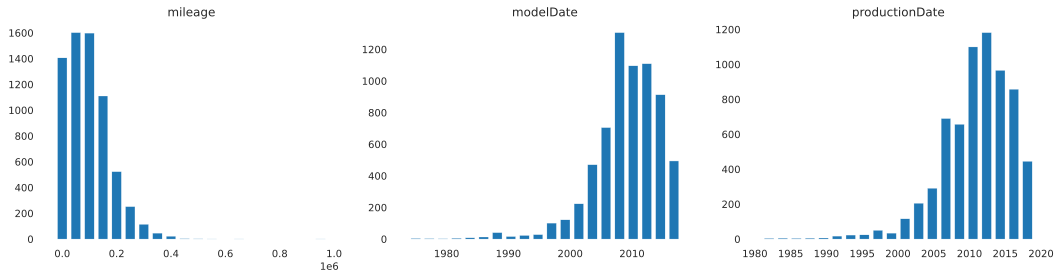

In [22]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [23]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы',  'ПТС', 'Привод', 'Руль']#,'name' 'Владение', 'enginePower',, 'engineDisplacement'

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate', ]

In [24]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [25]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    CURR_YEAR = 2021
    
    def calc_eng_power_2_user(row):
        n=3
        if row['Владельцы']=='3 или более': n=3
        if row['Владельцы']=='1 владелец': n=1
        if row['Владельцы']=='2 владельца': n=2
            
        return round(row['enginePowerD']/n,0)    
    
    df_output = df_input.copy()
    
    

        
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)

    
    
    # ################### Feature Engineering ####################################################

    def calc_km_per_year(row):
        if CURR_YEAR - row ['productionDate'] > 0:
            return row['mileage'] /  CURR_YEAR - row['productionDate']
        else:
            return row['mileage']
        
    def calc_enginePower2liter(row):
        if row ['engineDisplacement'] != 0:
            return np.log(row['enginePowerD'] / (row['engineDisplacement']) )
        else:
            return np.log(row['enginePowerD'])
        
    df_output['enginePowerD'] = df_output['enginePower']        
    #пробег за год    
    df_output['km_per_year'] = df_output.apply(calc_km_per_year, axis=1) 

    
    # enginePower в число
    kvt_filter = df_output['enginePowerD'].str.contains('\xa0кВт') #1.35962
    df_output['enginePowerD'] = df_output['enginePowerD'].str.replace(' N12','')
    df_output['enginePowerD'] = df_output['enginePowerD'].str.replace('\xa0кВт','')
    df_output['enginePowerD'] = df_output['enginePowerD'].astype('int32')
    df_output[kvt_filter]['enginePowerD'] = round(df_output[kvt_filter]['enginePowerD'] * 1.35962,0)# электрокары привели к ДВС
    
    #Потеря мощности от пробега
    df_output['km_per_year_power'] = np.log((df_output['enginePowerD'] / ( df_output['mileage']/15000))  *  (CURR_YEAR - df_output['productionDate']))
    
    df_output.loc[df_output['fuelType'] == 'электро','engineDisplacement'] = '0 LTR' # электрокары привели к ДВС
    df_output['engineDisplacement'] = df_output['engineDisplacement'].str.replace(' LTR','').astype('float')
   
    #мощность на литр - только ухудшает результат
#    df_output['enginePower2liter'] = df_output.apply(calc_enginePower2liter, axis=1) 
    
     #упрощенное имя - только ухудшает результат
#    df_output['name'] = df_output['name'].apply(lambda x: str(x).split()[0] + str(x).split()[1] ) #+ df_output['name'].apply(lambda x: str(x).split()[1])

    
    #modelDate -- productionDate
    df_output['modelDate'] = np.log(CURR_YEAR - df_output['modelDate'])
    df_output['productionDate'] = np.log(CURR_YEAR - df_output['productionDate'])
    df_output['mileage'] = np.log(df_output['mileage'])
    df_output['sell_id1'] = np.log(df_output['sell_id'])
    # Нормализация данных
    scaler = MinMaxScaler(feature_range=(-1,1))

    numerical_features.extend(['km_per_year','km_per_year_power', 'sell_id1', 'enginePowerD', 'engineDisplacement'])# 'enginePower2user', 'enginePower2liter'])

    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
        
    # ################### Categorical Features ############################################################## 
    # Label Encoding

    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать или недостаточно полные ->'Владение' , 
    drop_me = ['description', 'Владение',  'vehicleConfiguration', 'enginePower', 'name','sell_id']#
    df_output.drop(drop_me, axis = 1, inplace=True)
    
    #################### log price -> on predict np.exp('price')
    def calc_price_log(row):
        if row['sample'] == 1:
            return np.log(row['price'])
        else:
            return 0
    df_output['price'] = df_output.apply(calc_price_log, axis=1)
    return df_output

In [26]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,mileage,modelDate,productionDate,sample,price,enginePowerD,km_per_year,km_per_year_power,sell_id1,...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7399,-0.393939,0.676461,-2.216146e-01,-0.021848,1,14.279245,-0.4560,-0.777484,-0.710482,0.995321,...,1,0,0,0,1,0,0,1,1,0
4273,-0.393939,0.551071,-1.386469e-01,-0.121381,1,14.946913,-0.4560,-0.899134,-0.601973,0.999385,...,1,0,0,0,1,0,0,1,1,0
3362,0.666667,0.580121,-1.386469e-01,-0.021848,1,15.137266,0.6320,-0.876292,-0.466782,0.997040,...,0,0,1,0,1,0,0,1,1,0
2794,-0.090909,0.698970,2.220446e-16,0.257020,1,14.503645,-0.4560,-0.727920,-0.654099,0.987264,...,0,0,1,0,1,0,0,1,1,0
5378,-0.393939,0.724395,-1.386469e-01,-0.021848,1,14.066269,-0.5424,-0.697678,-0.781549,0.999741,...,0,0,1,0,1,0,0,1,1,0
5902,0.212121,0.614618,-6.546417e-02,0.135202,1,15.039286,0.5520,-0.840489,-0.465876,0.992604,...,1,0,0,0,1,0,0,1,1,0
1454,-0.090909,0.574118,-6.546417e-02,-0.021848,0,0.000000,-0.2160,-0.880537,-0.555929,0.999485,...,0,1,0,0,1,0,0,1,1,0
2476,-0.242424,0.746433,2.090620e-01,0.400249,1,13.458836,-0.5424,-0.624242,-0.683019,0.995818,...,0,0,1,1,0,1,0,0,1,0
743,-0.515152,0.693060,2.090620e-01,0.309051,0,0.000000,-0.8720,-0.733581,-0.752508,0.989532,...,0,0,1,0,1,1,0,0,1,0
1168,0.666667,0.518768,-6.546417e-02,0.062305,0,0.000000,0.5008,-0.908555,-0.386603,0.998046,...,0,0,1,0,1,0,0,1,1,0


In [27]:
df_preproc.describe()

,engineDisplacement,mileage,modelDate,productionDate,sample,price,enginePowerD,km_per_year,km_per_year_power,sell_id1,...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
count,8353.000000,8353.000000,8.353000e+03,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,...,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000
mean,-0.158350,0.636183,-2.198425e-02,0.103015,0.799952,11.315242,-0.422208,-0.740613,-0.635529,0.997265,...,0.302406,0.301089,0.396385,0.105232,0.894768,0.270442,0.104873,0.624686,0.999761,0.000239
std,0.320685,0.187897,3.152752e-01,0.345649,0.400060,5.698804,0.348428,0.169901,0.170509,0.046165,...,0.459328,0.458759,0.489175,0.306870,0.306870,0.444215,0.306407,0.484233,0.015473,0.015473
min,-1.000000,-1.000000,-1.000000e+00,-1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.393939,0.590886,-2.216146e-01,-0.121381,1.000000,13.038982,-0.651200,-0.866712,-0.729751,0.998328,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-0.151515,0.680969,2.220446e-16,0.135202,1.000000,13.845069,-0.500800,-0.760063,-0.668662,0.999546,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,-0.090909,0.740978,2.090620e-01,0.356552,1.000000,14.457364,-0.260800,-0.642413,-0.588255,0.999844,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000e+00,1.000000,1.000000,16.989389,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


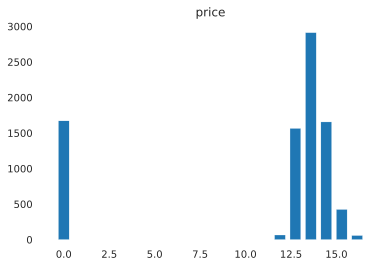

In [28]:
# Прологарифмировали цену - получили нормальное распределение
visualize_distributions({
    'price': df_preproc['price']})

In [29]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 191 entries, engineDisplacement to Руль_1
dtypes: float64(9), int64(1), uint8(181)
memory usage: 2.1 MB


## Split data

In [30]:
def price_exp_and_round(predicts, log_price=False, round_ = 25000 ):
    '''
    Развернем log в рубли
    Округлим  до 25000р
    '''
    #round_ = round_1#25000# 25000
    if log_price==True:
        predicts = np.exp(predicts)
    predicts = (predicts // round_) * round_
    return predicts

In [31]:
# Теперь выделим тестовую часть


train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [32]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 190 entries, engineDisplacement to Руль_1
dtypes: float64(9), uint8(181)
memory usage: 425.9 KB


In [33]:
# Посмотрим какие колонки получились
test_data.columns.to_list()

['engineDisplacement',
 'mileage',
 'modelDate',
 'productionDate',
 'price',
 'enginePowerD',
 'km_per_year',
 'km_per_year_power',
 'sell_id1',
 'bodyType_0',
 'bodyType_1',
 'bodyType_2',
 'bodyType_3',
 'bodyType_4',
 'bodyType_5',
 'bodyType_6',
 'bodyType_7',
 'bodyType_8',
 'bodyType_9',
 'bodyType_10',
 'bodyType_11',
 'bodyType_12',
 'bodyType_13',
 'bodyType_14',
 'bodyType_15',
 'bodyType_16',
 'brand_0',
 'brand_1',
 'brand_2',
 'color_0',
 'color_1',
 'color_2',
 'color_3',
 'color_4',
 'color_5',
 'color_6',
 'color_7',
 'color_8',
 'color_9',
 'color_10',
 'color_11',
 'color_12',
 'color_13',
 'color_14',
 'color_15',
 'fuelType_0',
 'fuelType_1',
 'fuelType_2',
 'fuelType_3',
 'model_info_0',
 'model_info_1',
 'model_info_2',
 'model_info_3',
 'model_info_4',
 'model_info_5',
 'model_info_6',
 'model_info_7',
 'model_info_8',
 'model_info_9',
 'model_info_10',
 'model_info_11',
 'model_info_12',
 'model_info_13',
 'model_info_14',
 'model_info_15',
 'model_info_16',
 '

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [35]:
# Вернем цену к обычному виду
y_train_1 = np.exp(y_train)
y_test_1 = np.exp(y_test)

# Model 2: CatBoostRegressor

In [36]:
model = CatBoostRegressor(iterations = 8000,
                          #depth=3,#10,
                          #learning_rate = 0.008, #0.023474
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

Learning rate set to 0.017515


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0420822	test: 0.0421393	best: 0.0421393 (0)	total: 55.5ms	remaining: 7m 24s
100:	learn: 0.0152892	test: 0.0149439	best: 0.0149439 (100)	total: 479ms	remaining: 37.5s
200:	learn: 0.0112228	test: 0.0110229	best: 0.0110229 (200)	total: 881ms	remaining: 34.2s
300:	learn: 0.0102918	test: 0.0100736	best: 0.0100736 (300)	total: 1.31s	remaining: 33.5s
400:	learn: 0.0098542	test: 0.0096957	best: 0.0096957 (400)	total: 1.76s	remaining: 33.4s
500:	learn: 0.0095324	test: 0.0094394	best: 0.0094394 (500)	total: 2.49s	remaining: 37.3s
600:	learn: 0.0092513	test: 0.0092140	best: 0.0092135 (599)	total: 3.01s	remaining: 37.1s
700:	learn: 0.0090157	test: 0.0090497	best: 0.0090493 (699)	total: 3.45s	remaining: 35.9s
800:	learn: 0.0087675	test: 0.0088930	best: 0.0088930 (800)	total: 3.83s	remaining: 34.4s
900:	learn: 0.0085503	test: 0.0087501	best: 0.0087499 (899)	total: 4.29s	remaining: 33.8s
1000:	learn: 0.0083273	test: 0.0085979	best: 0.0085979 (1000)	total: 4.68s	remaining: 32.7s
1100:	lear

In [37]:
test_predict_catboost = model.predict(X_test)
test_predict_catboost = price_exp_and_round(test_predict_catboost, log_price=True)
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_catboost, log_price=False))*100:0.2f}%")

TEST mape: 10.99%


TEST mape: 10.99%
Для примера TEST mape: 11.01% дает на leaderboard 11.89%

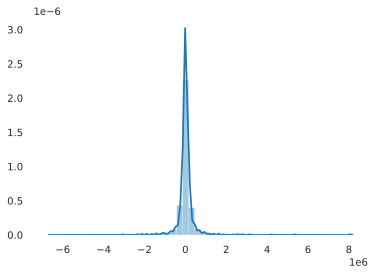

In [38]:
residuals_catboost = np.exp(y_test) - test_predict_catboost
sns.distplot(residuals_catboost)

### Submission

In [39]:
sub_predict_catboost = model.predict(X_sub)
sub_predict_catboost = price_exp_and_round(sub_predict_catboost, log_price=True)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [ ]:
X_train.head(5)

## Simple Dense NN

In [ ]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], kernel_initializer='lecun_normal', activation="relu"))
model.add(L.Dropout(0.5)) #0.5
model.add(L.BatchNormalization())

model.add(L.Dense(512, kernel_initializer='lecun_normal', activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.BatchNormalization())

model.add(L.Dense(256, kernel_initializer='lecun_normal', activation="relu"))
model.add(L.Dropout(0.5))


model.add(L.Dense(1, activation="linear"))

In [ ]:
#model.summary()

In [ ]:
# Compile model

optimizer = tf.keras.optimizers.Adam(0.001) #0.001 ##0.01 0.0051
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor='val_MAPE', verbose=1  , mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=70, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]


### Fit

In [ ]:
#Без log price - получается заметно точнее!!!

history = model.fit(X_train, y_train_1,
                    batch_size=256,##512,
                    epochs=700, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test_1),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [ ]:
test_predict_nn1 = model.predict(X_test)

print(f"TEST mape: {(mape(y_test_1, test_predict_nn1[:,0]))*100:0.2f}%")

In [ ]:
test_predict_nn1 = model.predict(X_test)
test_predict_nn1 = price_exp_and_round(test_predict_nn1[:,0],log_price=False, round_=10000)
print(f"TEST mape: {(mape(y_test_1, test_predict_nn1))*100:0.2f}%")

TEST mape: 10.84%  --- leader board 11.51713%

In [ ]:
sub_predict_nn1 = model.predict(X_sub)
sub_predict_nn1 = price_exp_and_round(sub_predict_nn1[:,0],log_price=False, round_=10000)
sample_submission['price'] = sub_predict_nn1
sample_submission.to_csv('nn1_submission.csv', index=False)

In [ ]:

residuals = y_test_1 - test_predict_nn1
sns.distplot(residuals)

# Model 4: NLP BERT + Multiple Inputs  
https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22

In [ ]:
# # A dependency of the preprocessing for BERT inputs
# !pip install -U tensorflow-text==2.3.0 # Нужна строго та же версия, что и TF

In [ ]:
# !pip install -q -U tf-models-official==2.3.0 # Нужна строго та же версия, что и TF

In [ ]:
# import shutil
# import tensorflow_hub as hub
# import tensorflow_text as text

In [ ]:
tfhub_handle_encoder = '../input/bert-multi-cased/bert_multi_cased_L-12_H-768_A-12_3' #'../input/bert-multi-cased/bert_multi_cased_preprocess_3/'
bert_model = hub.KerasLayer(tfhub_handle_encoder) 
tfhub_handle_preprocess = '../input/bert-multi-cased/bert_multi_cased_preprocess_3' #'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)


In [ ]:
# # Проверка работоспособности BERT
# text_test = ['Эндокринолог объяснила, каких гормонов не хватает человеку для счастья и как их восполнить'] #['this is such an amazing movie!']
# text_preprocessed = bert_preprocess_model(text_test)

# print(f'Keys       : {list(text_preprocessed.keys())}')
# print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
# print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
# print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

In [ ]:
def build_embedding_model():
    '''
    Получаем модельна базе embeddings Bert. 
    Весь препроцессинг так же здесь
    '''
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') #trainable=True
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output'] #тут эмбеддинги # [batch_size, 768].
    # Уменьшим размерность из 768 мерного эмбеддинга создадим свои 256 представлений-категорий
    net = L.Embedding(768+1, 256,)(net)
    net = L.Flatten()(net)
    net = L.Dense(256)(net)

    return tf.keras.Model(text_input, net)

In [ ]:
#text_test = "(your text here)"
embedding_model = build_embedding_model()
sentences = tf.constant(["(your text here)"])
print(embedding_model(sentences))

In [ ]:
data.description

In [39]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], kernel_initializer='glorot_uniform', activation=L.ReLU()))
model_mlp.add(L.Dropout(0.5)) #0.5
#model_mlp.add(L.BatchNormalization())

model_mlp.add(L.Dense(512, kernel_initializer='glorot_uniform',  activation=L.ReLU()))
model_mlp.add(L.Dropout(0.5))
#model_mlp.add(L.BatchNormalization())

model_mlp.add(L.Dense(256, kernel_initializer='glorot_uniform',  activation=L.ReLU()))
model_mlp.add(L.Dropout(0.5))


### Multiple Inputs NN

In [ ]:
#combinedInput = L.concatenate([model_nlp.output, model_mlp.output]) #embedding_model
combinedInput = L.concatenate([embedding_model.output, model_mlp.output]) #embedding_model
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)#64
head = L.Dropout(0.1)(head)
head = L.Dense(1, activation="linear")(head)

#model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)
model = Model(inputs=[embedding_model.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

### Fit

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True) #0.01 RMSProp
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor='val_MAPE', verbose=1, mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]


## Шаг 1 - результат 11.50154%



In [ ]:
#K.set_value(model.optimizer.learning_rate, 0.005)
history = model.fit([text_train, X_train], y_train_1,                    
                    batch_size=128,#,512,
                    epochs=700, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    #validation_data=([text_test_sequences, X_test], y_test), #text_test
                    validation_data=([text_test, X_test], y_test_1), #text_test
                    callbacks=callbacks_list,
                    verbose=1,
                   )

## Шаг 2 - уменьшим learning_rate до 0.0025 - 11.37604%

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')
#history = model.fit([text_train_sequences, X_train], y_train,
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0025)
history = model.fit([text_train, X_train], y_train_1,                    
                    batch_size=64,#,512,
                    epochs=700, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    #validation_data=([text_test_sequences, X_test], y_test), #text_test
                    validation_data=([text_test, X_test], y_test_1), #text_test
                    callbacks=callbacks_list,
                    verbose=1,
                   )

11.37604


## Шаг 3 learning rate 0.0025->0.001 11.25270%

In [ ]:
#history = model.fit([text_train_sequences, X_train], y_train,
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
history = model.fit([text_train, X_train], y_train_1,                    
                    batch_size=64,#,512,
                    epochs=700, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    #validation_data=([text_test_sequences, X_test], y_test), #text_test
                    validation_data=([text_test, X_test], y_test_1), #text_test
                    callbacks=callbacks_list,
                    verbose=1,
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [ ]:
test_predict_nn2 = model.predict([text_test, X_test])

In [ ]:

test_predict_nn2_1 = price_exp_and_round(test_predict_nn2[:,0],log_price=False, round_=1)
print(f"TEST mape: {(mape(y_test_1, test_predict_nn2_1, log_price=False))*100:0.2f}%")

In [ ]:
test_predict_nn2_2 = price_exp_and_round(test_predict_nn2[:,0],log_price=False, round_=1000)
print(f"TEST mape: {(mape(y_test_1, test_predict_nn2_2))*100:0.2f}%")

# TEST mape: 11.25%

In [ ]:
residuals = y_test_1 - test_predict_nn2_2
sns.distplot(residuals)

In [ ]:
sub_predict_nn2_2 = model.predict([text_sub, X_sub])
sub_predict_nn2_3 = price_exp_and_round(sub_predict_nn2_2[:,0],log_price=False, round_=1000)
sample_submission['price'] = sub_predict_nn2_3
sample_submission.to_csv('nn2_submission.csv', index=False)

In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sub_predict_nn2_1 = price_exp_and_round(sub_predict_nn2[:,0],log_price=False, round_=10000)
sample_submission['price'] = sub_predict_nn2_1
sample_submission.to_csv('nn2_submission.csv', index=False)

# Model 5: Добавляем картинки

## Text Doc2Vec + Keras

In [40]:
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [41]:
#Работаем с текстом из description - получаем эмбеддинги
RUN_FROM_0 = True
text_featuers_model = TextFeatures(RANDOM_SEED, 3,\
                   ['!','.','•',')','(',':','[',']','*','-','_','пао','ooo','акб','https ://','http ://','https://','http://'])
if RUN_FROM_0:
    text_featuers_model.train(text_train)
    text_featuers_model.model.save('DOC2VEC_model.model')
else:
     text_featuers_model.model = gensim.models.doc2vec.Doc2Vec.load('../input/langdata1/DOC2VEC_model.model')#'DOC2VEC_model.model')





Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [42]:
# Получим эмбеддинги для Теста
textF_test = np.stack(text_test.progress_apply(text_featuers_model.infer))

In [43]:
# Получим эмбеддинги для Теста и Трейна
textF_train = text_featuers_model.model.docvecs.vectors_docs  #doctag_syn0

In [44]:
# Получим эмбеддинги для Сабмита
textF_sub = np.stack(text_sub.progress_apply(text_featuers_model.infer))


### Data

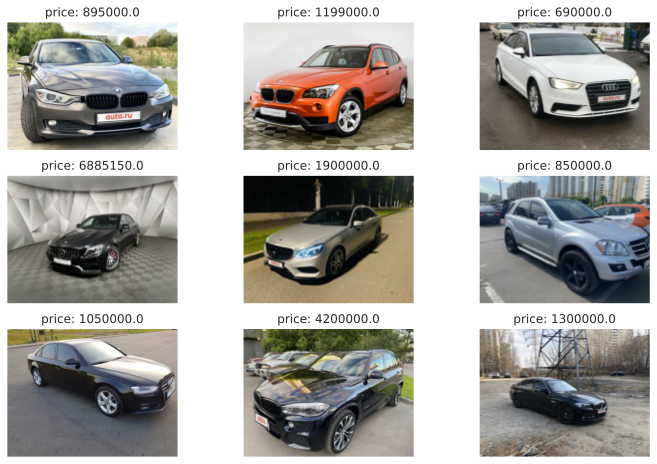

In [45]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [46]:
size = (224,224) #(320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 224, 224, 3) dtype uint8
images shape (1003, 224, 224, 3) dtype uint8
images shape (1671, 224, 224, 3) dtype uint8


### albumentations

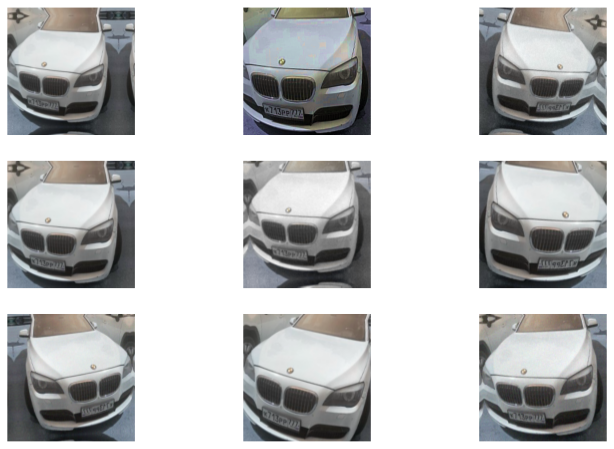

In [47]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [48]:
def process_image(image):
    return augmentation(image = image.numpy())['image']
# Оставим как пример - вся предобработка выполняется в модели 
# def tokenize_(descriptions):
#     return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

# def tokenize_text(text):
#     return tokenize_([text.numpy().decode('utf-8')])[0]

# def tf_process_train_dataset_element(image, table_data, text, price):
#     im_shape = image.shape
#     [image,] = tf.py_function(process_image, [image], [tf.uint8])
#     image.set_shape(im_shape)
#     [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
#     return (image, table_data, text), price

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    #[text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    #[text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
#    images_train, X_train, data.description.iloc[X_train.index], y_train_1
    images_train, X_train, textF_train, y_train_1    
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
#     images_test, X_test, data.description.iloc[X_test.index], y_test_1
    images_test, X_test, textF_test, y_test_1
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
#     images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    images_sub, X_sub, textF_sub, y_sub
    )).map(tf_process_val_dataset_element)


#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

print("--OK--")

--OK--


### Строим сверточную сеть для анализа изображений без "головы"

In [49]:
# EfficientNetB3 обученная на 'imagenet' дает хуже результат (на 0.2) чем использование тюнненной EfficientNetB5 из соревнования Ford vs Ferrary

#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
# efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
# efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)
 

# Загружаем тюнненную EfficientNetB5 из соревнования Ford vs Ferrary
base_model = tf.keras.applications.efficientnet.EfficientNetB5(weights='../input/efficientnetb5/efficientnetb5_notop.h5', include_top=False, input_shape=(224,224,3), drop_connect_rate=0.2)
x = base_model.output
x = L.GlobalAveragePooling2D()(x)

x = L.Dense(256, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=RANDOM_SEED))(x)
x = L.BatchNormalization(name='ADD_bn_1')(x)
x = L.Dropout(0.5)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = L.Dense(10, activation='softmax')(x)

# Загружаем НАШИ веса и ЗАТЕМ отрезаем классификатор
model1 = keras.Model(inputs=base_model.input, outputs=predictions)
model1.load_weights('../input/efficientnetb5/best_model_50perc_st2.hdf5')

efficientnet_model = Model(model1.input, base_model.layers[-6].output)
efficientnet_model.layers[0]._name = 'input_eff1'
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [50]:
efficientnet_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_eff1 (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_eff1[0][0]                 
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [51]:
#строим нейросеть для анализа табличных данных

tabular_model = Sequential()
tabular_model.add(L.Dense(512, input_dim=X_train.shape[1], kernel_initializer='lecun_normal', activation="relu"))
#tabular_model.add(L.BatchNormalization(momentum=0.8))
tabular_model.add(L.Dropout(0.5)) #0.5

tabular_model.add(L.Dense(512, kernel_initializer='lecun_normal', activation="relu"))
#tabular_model.add(L.BatchNormalization(momentum=0.8))
tabular_model.add(L.Dropout(0.5))

tabular_model.add(L.Dense(256, kernel_initializer='lecun_normal', activation="relu"))
tabular_model.add(L.Dropout(0.5))


In [52]:
# FEATURE Input
# Input
emb_txt_in = L.Input(shape=([50]), name="emb")
# Embeddings layers
#emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)

emb_txt_out = emb_txt_in

In [53]:
#объединяем выходы трех нейросетей
#combinedInput = L.concatenate([efficientnet_output, tabular_model.output, embedding_model.output])
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, emb_txt_out])
# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dropout(0.15)(head)
head = L.Dense(1,)(head)


#model = Model(inputs=[efficientnet_model.input, tabular_model.input, embedding_model.input], outputs=head)
model = Model(inputs=[efficientnet_model.input, tabular_model.input, emb_txt_in], outputs=head)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_eff1 (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_eff1[0][0]                 
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [54]:
optimizer = tf.keras.optimizers.Adam(0.005) #0.05
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [55]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor='val_MAPE', verbose=1, mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]


In [56]:
# ШАГ №1 lr=0.005  Результат 11.44502% 0.005
BATCH = 30 #30
history = model.fit(train_dataset.batch(BATCH),
                    epochs=100,
                    validation_data = test_dataset.batch(BATCH),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - ETA: 0s - loss: 42.0702 - MAPE: 42.0702
Epoch 00001: val_MAPE improved from inf to 83.55792, saving model to ../working/best_model.hdf5
190/190 [==============================] - 131s 690ms/step - loss: 42.0702 - MAPE: 42.0702 - val_loss: 83.5579 - val_MAPE: 83.5579
Epoch 2/100
190/190 [==============================] - ETA: 0s - loss: 20.2665 - MAPE: 20.2665
Epoch 00002: val_MAPE improved from 83.55792 to 26.59988, saving model to ../working/best_model.hdf5
190/190 [==============================] - 126s 663ms/step - loss: 20.2665 - MAPE: 20.2665 - val_loss: 26.5999 - val_MAPE: 26.5999
Epoch 3/100
190/190 [==============================] - ETA: 0s - loss: 18.9213 - MAPE: 18.9213
Epoch 00003: val_MAPE improved from 26.59988 to 26.11574, saving model to ../working/best_model.hdf5
190/190 [==============================] - 126s 661ms/step - loss: 18.9213 - MAPE: 18.9213 - val_loss: 26.1157 - val_MAPE: 26.1157
Epoch 4/100
190/190 [===

190/190 [==============================] - ETA: 0s - loss: 14.3797 - MAPE: 14.3797
Epoch 00028: val_MAPE improved from 11.90898 to 11.82699, saving model to ../working/best_model.hdf5
190/190 [==============================] - 125s 656ms/step - loss: 14.3797 - MAPE: 14.3797 - val_loss: 11.8270 - val_MAPE: 11.8270
Epoch 29/100
190/190 [==============================] - ETA: 0s - loss: 14.2216 - MAPE: 14.2216
Epoch 00029: val_MAPE did not improve from 11.82699
190/190 [==============================] - 123s 646ms/step - loss: 14.2216 - MAPE: 14.2216 - val_loss: 12.1075 - val_MAPE: 12.1075
Epoch 30/100
190/190 [==============================] - ETA: 0s - loss: 14.1411 - MAPE: 14.1411
Epoch 00030: val_MAPE improved from 11.82699 to 11.69118, saving model to ../working/best_model.hdf5
190/190 [==============================] - 125s 660ms/step - loss: 14.1411 - MAPE: 14.1411 - val_loss: 11.6912 - val_MAPE: 11.6912
Epoch 31/100
190/190 [==============================] - ETA: 0s - loss: 14.183

KeyboardInterrupt: 

In [57]:
# ШАГ №2 lr=0.0025  Результат 11.44502%
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0025)

BATCH = 30 #30
history = model.fit(train_dataset.batch(BATCH),
                    epochs=100,
                    validation_data = test_dataset.batch(BATCH),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - ETA: 0s - loss: 13.2741 - MAPE: 13.2741
Epoch 00001: val_MAPE did not improve from 11.44502
190/190 [==============================] - 122s 644ms/step - loss: 13.2741 - MAPE: 13.2741 - val_loss: 11.5968 - val_MAPE: 11.5968
Epoch 2/100
190/190 [==============================] - ETA: 0s - loss: 13.0870 - MAPE: 13.0870
Epoch 00002: val_MAPE did not improve from 11.44502
190/190 [==============================] - 122s 642ms/step - loss: 13.0870 - MAPE: 13.0870 - val_loss: 11.8908 - val_MAPE: 11.8908
Epoch 3/100
190/190 [==============================] - ETA: 0s - loss: 13.1685 - MAPE: 13.1685
Epoch 00003: val_MAPE did not improve from 11.44502
190/190 [==============================] - 122s 643ms/step - loss: 13.1685 - MAPE: 13.1685 - val_loss: 11.4783 - val_MAPE: 11.4783
Epoch 4/100
190/190 [==============================] - ETA: 0s - loss: 12.8400 - MAPE: 12.8400
Epoch 00004: val_MAPE did not improve from 11.44502
190/190 [==========

KeyboardInterrupt: 

In [58]:
# ШАГ №3 lr=0.001  Результат 11.21254%
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)

BATCH = 40 #30
history = model.fit(train_dataset.batch(BATCH),
                    epochs=100,
                    validation_data = test_dataset.batch(BATCH),
                    callbacks=callbacks_list
                   )

Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 13.0023 - MAPE: 13.0023
Epoch 00001: val_MAPE improved from 11.44502 to 11.31276, saving model to ../working/best_model.hdf5
142/142 [==============================] - 124s 871ms/step - loss: 13.0023 - MAPE: 13.0023 - val_loss: 11.3128 - val_MAPE: 11.3128
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 12.9830 - MAPE: 12.9830
Epoch 00002: val_MAPE did not improve from 11.31276
142/142 [==============================] - 120s 844ms/step - loss: 12.9830 - MAPE: 12.9830 - val_loss: 11.3410 - val_MAPE: 11.3410
Epoch 3/100
142/142 [==============================] - ETA: 0s - loss: 12.6723 - MAPE: 12.6723
Epoch 00003: val_MAPE improved from 11.31276 to 11.23726, saving model to ../working/best_model.hdf5
142/142 [==============================] - 123s 865ms/step - loss: 12.6723 - MAPE: 12.6723 - val_loss: 11.2373 - val_MAPE: 11.2373
Epoch 4/100
142/142 [==============================] - ETA: 0s - los

KeyboardInterrupt: 

In [59]:
# ШАГ №4 lr=0.0005  
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0005)

BATCH = 40 #30
history = model.fit(train_dataset.batch(BATCH),
                    epochs=100,
                    validation_data = test_dataset.batch(BATCH),
                    callbacks=callbacks_list
                   )

Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 12.1244 - MAPE: 12.1244
Epoch 00001: val_MAPE did not improve from 11.14850
142/142 [==============================] - 120s 847ms/step - loss: 12.1244 - MAPE: 12.1244 - val_loss: 11.1722 - val_MAPE: 11.1722
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 12.3861 - MAPE: 12.3861
Epoch 00002: val_MAPE did not improve from 11.14850
142/142 [==============================] - 121s 849ms/step - loss: 12.3861 - MAPE: 12.3861 - val_loss: 11.1675 - val_MAPE: 11.1675
Epoch 3/100
142/142 [==============================] - ETA: 0s - loss: 12.2963 - MAPE: 12.2963
Epoch 00003: val_MAPE did not improve from 11.14850
142/142 [==============================] - 120s 848ms/step - loss: 12.2963 - MAPE: 12.2963 - val_loss: 11.1546 - val_MAPE: 11.1546
Epoch 4/100
142/142 [==============================] - ETA: 0s - loss: 12.1798 - MAPE: 12.1798
Epoch 00004: val_MAPE did not improve from 11.14850
142/142 [==========

KeyboardInterrupt: 

In [60]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

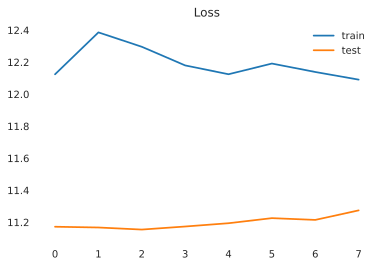

In [61]:
plt.title('Loss')
plt.plot(model.history.history['MAPE'], label='train')
plt.plot(model.history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [68]:
test_predict_nn3 = model.predict(test_dataset.batch(10))
print(f"TEST mape: {(mape(y_test_1, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.15%


In [65]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

**BERT**  TEST mape: 11.69% --> leader board = 12.27499%  
**Mystem Doc2Vec**  TEST mape: 11.20%  -> 11.79%  

# Blend ((CNN-табличный + BERT + EfficientNetB3) + CatBoost )/2

In [69]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test_1, blend_predict))*100:0.2f}%")

TEST mape: 10.44%


BERT embeddings:    
10.47% --> 10.96% С помомощью тюненной сети из Ford vs Ferrary 

Mystem Doc2Vec:  
10.44% --> 11.0% С помомощью тюненной сети из Ford vs Ferrary  [](http://)

In [70]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission-fin.csv', index=False)

## Blending CatBoost + CNN 

In [ ]:
blend_predict_simple = (test_predict_catboost + test_predict_nn1) / 2
print(f"TEST mape: {(mape(y_test_1, blend_predict_simple))*100:0.2f}%")

TEST mape: 10.22% --> 10.93%

In [ ]:
blend_sub_predict_simple = (sub_predict_catboost + sub_predict_nn1) / 2
sample_submission['price'] = blend_sub_predict_simple
sample_submission.to_csv('blend_submission-simple-fin.csv', index=False)

# Blending CatBoost + CNN -> Leader board 10.92507% что ЛУЧШЕ чем более сложная модель Blend (CNN-табличный + BERT + EfficientNetB3) + CatBoost ) 10.96%